# 3.7.2 XNN Model Testing / Interpretation

## 1) Load Required Libraries

In [16]:
library("dplyr")
library("ggplot2")
library("caret")
library("mltools")
library("data.table")
library("pROC")
library("PRROC")
library("MLmetrics")


Attaching package: ‘MLmetrics’

The following objects are masked from ‘package:caret’:

    MAE, RMSE

The following object is masked from ‘package:base’:

    Recall



## 2) Load Data

### 2.1) Test Data

In [2]:
test.1hot.df <- read.csv(file="./data/new.test.1hot.df.csv", header=TRUE, sep=",")
glimpse(test.1hot.df)

Observations: 51,159
Variables: 45
$ X                                      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…
$ loan_amnt                              <int> 12200, 9325, 15000, 15000, 400…
$ term_36MO                              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ term_60MO                              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ int_rate                               <dbl> 12.29, 12.53, 11.89, 13.16, 12…
$ installment                            <dbl> 406.91, 312.08, 497.46, 506.56…
$ grade_A                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, …
$ grade_B                                <int> 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, …
$ grade_C                                <int> 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, …
$ grade_D                                <int> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, …
$ grade_E                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_F                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_G        

In [3]:
y_test <- subset(test.1hot.df, select=default)

### 2.2) XNN Probabilities

In [4]:
xnn.prob.df <- read.csv(file="./pred/XNN_prob.csv", header=TRUE, sep=",")
glimpse(xnn.prob.df)

Observations: 51,159
Variables: 2
$ X        <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…
$ XNN_prob <dbl> 0.15377873, 0.27356870, 0.15619719, 0.18449620, 0.14224678, …


### 2.3) Calculate Sampled Medians (for Cost Sensitive Evaluation)
#### On test dataset because it's evaluation

Calculate median sample returns

In [5]:
mreturns <- mean((test.1hot.df %>% mutate(returns = ((installment * term_36MO * 36) + (installment * term_60MO * 60)) - loan_amnt))$returns)
mreturns

[1] 4137.981

Median sample loan amount

In [6]:
mloan_amnt <- mean(test.1hot.df$loan_amnt)
mloan_amnt

[1] 13535.83

## 3) Cost Sensitive Evaluation 
#### on XNN probabilities

### 3.1) Find optimal Threshold

In [7]:
xnn.res.df <- data.frame(Threshold=0, CR=0, Profit=0, stringsAsFactors=FALSE)
threshs <- seq(0.03, 0.5725, by = 0.0025)
crs <- c()
rets <- c()
for(i in 1:length(threshs)) {
    cm <- confusionMatrix(table(xnn.prob.df$XNN_prob > threshs[i], y_test$default))
    nir <- sum(cm$table[,1])/sum(cm$table)
    cr <-  ((cm$table[1,2]*mloan_amnt)+(cm$table[2,1]*mreturns)) / (sum(cm$table[,1])*mreturns)
    pr <-  (cm$table[1,1]*mreturns) - (cm$table[1,2]*mloan_amnt)
    nv <- (round(nir * sum(cm$table[1,]),0)*mreturns)-(round((1-nir) * sum(cm$table[1,]),0)*mloan_amnt)
    crs <- c(crs,pr)
    rets <- c(rets, sum(cm$table[1,])*mreturns)
    xnn.res.df[nrow(xnn.res.df) + 1,] = list(threshs[i],cr,pr)
}
max(pr) #xgb.mono.CSL.cv.opt2.threshold = 0.035, 0.26

[1] 45274234

In [8]:
xnn.res.df[which(xnn.res.df$Profit > 60000000),] %>% arrange(-Profit)

Threshold,CR,Profit
0.2600,0.6062130,68017892
0.2675,0.6064838,67971115
0.2650,0.6065306,67963025
0.2700,0.6066047,67950238
0.2625,0.6066842,67936490
0.2725,0.6070715,67869608
0.2825,0.6081984,67674945
0.2525,0.6082371,67668268
0.2575,0.6083956,67640896
0.2750,0.6087921,67572406


In [9]:
xnn.threshold <- 0.26

### 3.2) Save Predictions using this threshold

In [134]:
XNN.pred.df <- as.data.frame(xnn.prob.df$XNN_prob > xnn.threshold)
colnames(XNN.pred.df) <- c("XNN_pred")

In [135]:
write.csv(XNN.pred.df , file = "./pred/XNN_pred.csv")

## 4) Model Testing

### 4.1) Confusion Matrix

In [10]:
xnn.cm <- confusionMatrix(table(xnn.prob.df$XNN_prob > xnn.threshold, y_test$default))
xnn.cm

Confusion Matrix and Statistics

       
        FALSE  TRUE
  FALSE 30500  4299
  TRUE  11242  5118
                                          
               Accuracy : 0.6962          
                 95% CI : (0.6922, 0.7002)
    No Information Rate : 0.8159          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2133          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7307          
            Specificity : 0.5435          
         Pos Pred Value : 0.8765          
         Neg Pred Value : 0.3128          
             Prevalence : 0.8159          
         Detection Rate : 0.5962          
   Detection Prevalence : 0.6802          
      Balanced Accuracy : 0.6371          
                                          
       'Positive' Class : FALSE           
                                       

### 4.2) Profit Lift

In [11]:
pr <-  (xnn.cm$table[1,1]*mreturns) - (xnn.cm$table[1,2]*mloan_amnt)
nv <- (round(nir * sum(xnn.cm$table[1,]),0)*mreturns)-(round((1-nir) * sum(xnn.cm$table[1,]),0)*mloan_amnt)
pr / nv

[1] 2.209868

In [18]:
cr <-  ((xnn.cm$table[1,2]*mloan_amnt)+(xnn.cm$table[2,1]*mreturns)) / (sum(xnn.cm$table[,1])*mreturns)
cr

[1] 0.606213

### 4.3) ROC/PR Curves

In [12]:
xnn.pred.fg <- xnn.prob.df$XNN_prob[y_test$default==TRUE]
xnn.pred.bg <- xnn.prob.df$XNN_prob[y_test$default==FALSE]

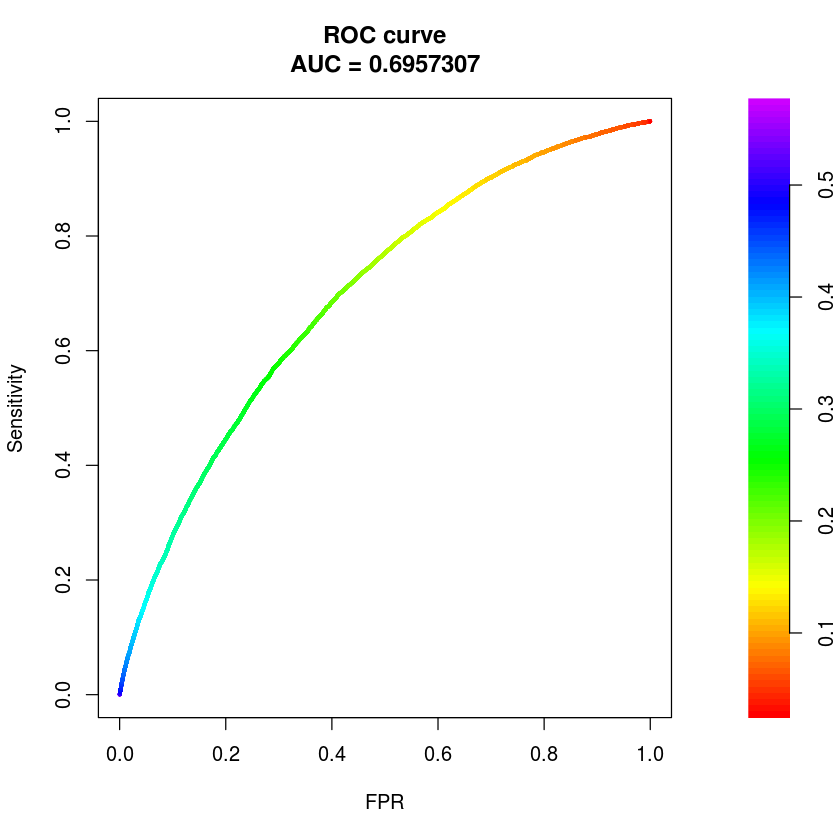

In [13]:
xnn.pred.roc <- roc.curve(scores.class0 = xnn.pred.fg, scores.class1 = xnn.pred.bg, curve = T)
plot(xnn.pred.roc)

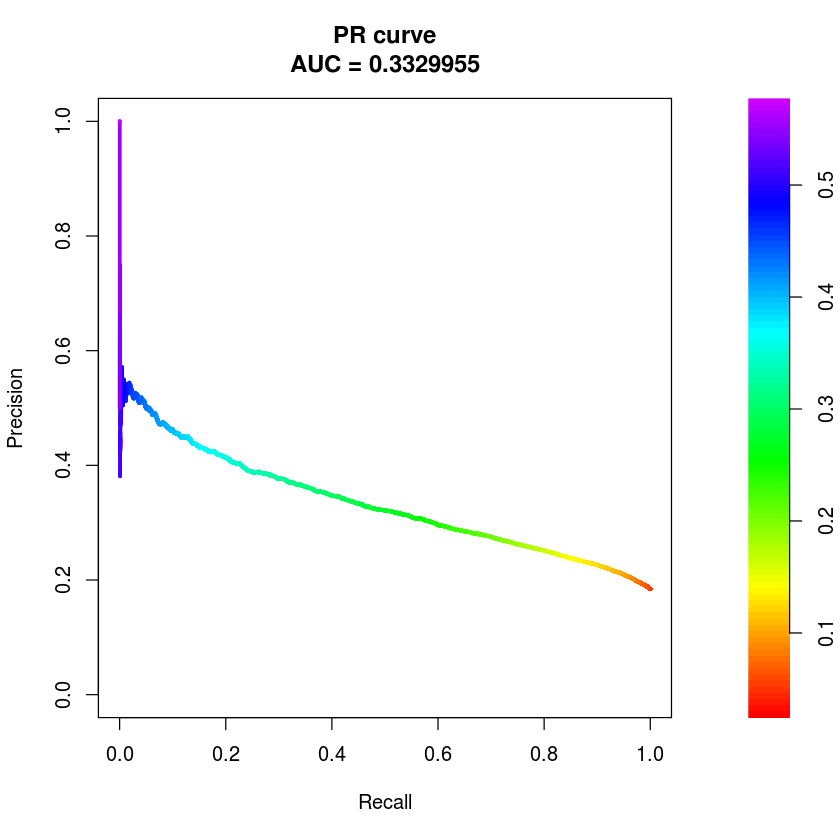

In [14]:
xnn.pred.prc <- pr.curve(scores.class0 = xnn.pred.fg, scores.class1 = xnn.pred.bg, curve = T)
plot(xnn.pred.prc)

### 4.4) F1 Score

In [17]:
xnn.pred.f1 <- F1_Score(ifelse(xnn.prob.df$XNN_prob > xnn.threshold, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xnn.pred.f1

[1] 0.7969585